# MLP class

In [2]:
import numpy as np
from sklearn.metrics import f1_score

In [3]:
import copy

class MLP:
    def __init__(self, layer_sizes, act_fun='sigmoid', out_act_fun_name = 'linear', loss_fun_name = 'mse', metric = 'mse'):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.set_act_fun(act_fun)
        self.set_out_act_fun(out_act_fun_name)
        self.set_loss_fun(loss_fun_name)
        self.metric = metric
        
        self.weights = [None] * (self.n_layers - 1)
        self.biases = [None] * (self.n_layers - 1)
        self.initialize_weights()

    def initialize_weights(self):
        for i in range(self.n_layers - 1):
            self.weights[i] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.random.rand(self.layer_sizes[i + 1], 1)        

    def _forward(self, X, return_activations = False):
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        Y = X
        if return_activations: A = []

        for i in range(self.n_layers - 2):
            Y = np.dot(Y, self.weights[i]) + self.biases[i].T
            if return_activations:
                A.append(Y)
            Y = self.act_fun(Y)
        Y = np.dot(Y, self.weights[-1]) + self.biases[-1].T
        if return_activations:
            A.append(Y)
        Y = self.out_act_fun(Y)
        return Y if not return_activations else (Y, A)

    def predict(self, X):
        return self._forward(X)
    
    def _backward(self, X, Y, batch_size):
        Y = np.atleast_2d(Y)
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        if Y.shape[0] == 1:
            Y = Y.reshape(-1, 1)
        Y_pred, A = self._forward(X, return_activations = True)
        error = Y_pred - Y
        D_weights = []
        D_biases = []
        E = np.array([])
        for i in range(len(self.weights) - 1, -1, -1):
            if i == len(self.weights) - 1:
                if self.loss_fun_name == 'cross_entropy' and self.out_act_fun_name == 'softmax':
                    E = error
                elif self.loss_fun_name == 'mse':
                    E = error * self.out_act_fun_prime(A[i])
            else:
                E = np.dot(E, self.weights[i + 1].T) * self.act_fun_prime(A[i])
            D_weights.insert(0, np.dot(self.act_fun(A[i - 1]).T, E) / batch_size if i > 0 else np.dot(X.T, E) / batch_size)
            D_biases.insert(0, np.sum(E, axis=0).reshape(-1, 1) / batch_size)
        return D_weights, D_biases
        

    def _momentum_update(self, D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate):
        for i in range(len(self.weights)):
            momentum_w[i] = - D_weights[i] + momentum_coef * momentum_w[i]
            momentum_b[i] = - D_biases[i] + momentum_coef * momentum_b[i]
            self.weights[i] += learning_rate * momentum_w[i]
            self.biases[i] += learning_rate * momentum_b[i]
        return momentum_w, momentum_b
    
    def _RMSProp_update(self, D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate):
        for i in range(len(self.weights)):
            E_w[i] = beta * E_w[i] + (1 - beta) * D_weights[i] ** 2
            E_b[i] = beta * E_b[i] + (1 - beta) * D_biases[i] ** 2
            self.weights[i] -= learning_rate * D_weights[i] / (np.sqrt(E_w[i] + epsilon))
            self.biases[i] -= learning_rate * D_biases[i] / (np.sqrt(E_b[i] + epsilon))
        return E_w, E_b
    
    def fit(self, X, Y, first_lr = 0.01, lr_decay_rate=0, momentum_coef=0.9, epochs = 100, n_epochs_displayed = 100, optimizer=None, beta=0.9, epsilon=1e-8, track_weights=False, batch_size=32, return_metrics=False):
        X = np.array(X)
        Y = np.array(Y)
        losses = []
        metrics = []
        if track_weights:
            weights_over_epochs = [copy.deepcopy(self.weights)]
            biases_over_epochs = [copy.deepcopy(self.biases)]
        else:
            weights_over_epochs = []
            biases_over_epochs = []
            
        if optimizer == 'momentum':
            momentum_w = [np.zeros(w.shape) for w in self.weights]
            momentum_b = [np.zeros(b.shape) for b in self.biases]

        if optimizer == 'RMSProp':
            E_w = [np.zeros(w.shape) for w in self.weights]
            E_b = [np.zeros(b.shape) for b in self.biases]

        for epoch in range(epochs):
            permutaion = np.random.permutation(X.shape[0])
            learning_rate = first_lr / (1 + epoch * lr_decay_rate)
            for i in range(0, X.shape[0], batch_size):
                D_weights, D_biases = self._backward(X[permutaion[i:i + batch_size]], Y[permutaion[i:i + batch_size]], batch_size)

                if not optimizer:
                    for j in range(len(self.weights)):
                        self.weights[j] -= learning_rate * D_weights[j]
                        self.biases[j] -= learning_rate * D_biases[j]
                elif optimizer == 'momentum':
                    momentum_w, momentum_b = self._momentum_update(D_weights, D_biases, momentum_coef, momentum_w, momentum_b, learning_rate)
                elif optimizer == 'RMSProp':
                    E_w, E_b = self._RMSProp_update(D_weights, D_biases, beta, epsilon, E_w, E_b, learning_rate)
            Y_pred = self.predict(X)
            losses.append(self.loss_fun(Y, Y_pred))
            if return_metrics:
                if self.metric == 'f1':
                    metrics.append(f1_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1), average="macro"))
            if track_weights:
                weights_over_epochs.append(copy.deepcopy(self.weights))
                biases_over_epochs.append(copy.deepcopy(self.biases))
            if epoch == 0 or (epoch + 1) % n_epochs_displayed == 0:
                if self.metric == 'mse':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}')
                elif self.metric == 'f1':
                    print(f'Epoch {epoch + 1}: loss_fun={losses[-1]}, f1_score={f1_score(np.argmax(Y, axis=1), np.argmax(Y_pred, axis=1), average="macro")}')
        if track_weights and return_metrics:
            return losses, metrics, weights_over_epochs, biases_over_epochs
        elif track_weights:
            return losses, weights_over_epochs, biases_over_epochs
        elif return_metrics:
            return losses, metrics
        else:
            return losses
                
    def set_all_weights(self, weights):
        self.weights = weights

    def set_weights_for_layer(self, layer, weights):
        self.weights[layer] = weights

    def set_weigth(self, layer, from_neuron, to_neuron, value):
        self.weights[layer][from_neuron][to_neuron] = value

    def set_all_biases(self, biases):
        self.biases = biases

    def set_biases_for_layer(self, layer, biases):
        self.biases[layer] = biases

    def set_bias(self, layer, neuron, value):
        self.biases[layer][neuron] = value

    def set_act_fun(self, act_fun):
        act_fun_prime = None
        if act_fun == 'sigmoid':
            act_fun = lambda x: 1 / (1 + np.exp(-x))
            act_fun_prime = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

        if act_fun == 'relu':
            act_fun = lambda x: np.maximum(0, x)
            act_fun_prime = lambda x: np.where(x > 0, 1, 0)

        if act_fun == 'tanh':
            act_fun = lambda x: np.tanh(x)
            act_fun_prime = lambda x: 1 - np.tanh(x) ** 2

        if act_fun == 'linear':
            act_fun = lambda x: x
            act_fun_prime = lambda x: np.ones_like(x)
            
        self.act_fun = act_fun
        self.act_fun_prime = act_fun_prime

    def set_out_act_fun(self, out_act_fun_name):
        if not out_act_fun_name:
            out_act_fun_name = 'linear'
        if out_act_fun_name == 'linear':
            out_act_fun = lambda x: x
            out_act_fun_prime = lambda x: np.ones_like(x)
        elif out_act_fun_name == 'softmax':
            out_act_fun = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
            out_act_fun_prime = lambda x: np.exp(x) * (1 - np.exp(x)) / np.sum(np.exp(x), axis=1, keepdims=True) ** 2
        self.out_act_fun_name = out_act_fun_name
        self.out_act_fun = out_act_fun
        self.out_act_fun_prime = out_act_fun_prime

    def set_loss_fun(self, loss_fun_name):
        self.loss_fun_name = loss_fun_name
        def _mse(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return np.mean((y - y_pred) ** 2) / 2
        
        def _cross_entropy(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return -np.mean(np.sum(y * np.log(y_pred + 1e-15), axis=1))
        
        if loss_fun_name == 'mse':
            self.loss_fun = lambda y, y_pred: _mse(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: y_pred - y
        elif loss_fun_name == 'cross_entropy':
            self.loss_fun = lambda y, y_pred: _cross_entropy(y, y_pred)
            self.loss_fun_prime = lambda y, y_pred: - (y / (y_pred + 1e-15)) / y.shape[0]
    

    

    

In [4]:
def normalize(data, min = None, max = None):
    data = np.array(data)
    if min is None:
        min = np.min(data, axis=0)

    if max is None:
        max = np.max(data, axis=0)

    return (data - min) / (max - min), min, max    

In [5]:
def denormalize(data, min, max):
    data = np.array(data)
    return data * (max - min) + min

# Functions for visualisation

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [7]:
def draw_network_for_epoch(weights, biases, epoch):
    G = nx.Graph()
    n_layers = len(weights) + 1
    n_neurons = [len(layer) for layer in weights] + [len(biases[-1])]

    max_abs_weight = max([np.max(np.abs(layer)) for layer in weights])

    for i in range(n_layers):
        for j in range(n_neurons[i]):
            G.add_node(f'{i}-{j}')
    for i in range(n_layers - 1):
        for j in range(n_neurons[i]):
            for k in range(n_neurons[i + 1]):
                G.add_edge(f'{i}-{j}', f'{i + 1}-{k}', weight=weights[i][j][k])
    
    pos = {}
    max_n_neurons = max(n_neurons)
    for i in range(n_layers):
        for j in range(n_neurons[i]):
            pos[f'{i}-{j}'] = (i, max_n_neurons - n_neurons[i] + 2 * j)
    
    cmap = plt.get_cmap('RdYlGn')
    norm = plt.Normalize(vmin=-max_abs_weight, vmax=max_abs_weight)
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges()]

    plt.figure(figsize=(10, 10))
    plt.title(f'Epoch {epoch}')
    nx.draw(
        G, 
        pos,
        edge_color=edge_colors,
        node_size=3000, 
        font_size=10, 
        width=[abs(G[u][v]['weight']) + 1 for u, v in G.edges()]
    )
    node_labels = {f'{i+1}-{j}': f'{biases[i][j][0]:.2f}' for i in range(n_layers - 1) for j in range(n_neurons[i + 1])}
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{G[u][v]["weight"]:.2f}' for u, v in G.edges()})
    plt.show()

In [8]:
def draw_networks_for_epochs(weights_over_epochs, biases_over_epochs, epochs):
    for epoch in epochs:
        draw_network_for_epoch(weights_over_epochs[epoch], biases_over_epochs[epoch], epoch)

In [9]:
def train_and_draw_plots(model, X_train, Y_train, X_test, Y_test, first_lr, epochs, lr_decay_rate=0, n_epochs_displayed = 100, batch_size = 32, momentum_coef = 0.9, beta = 0.9, epsilon = 1e-8, optimizer=None, return_metrics=False):
    
    X_train_norm, x_min, x_max = normalize(X_train)
    if model.loss_fun_name == 'mse':
        Y_train_norm, y_min, y_max = normalize(Y_train)
    else:
        Y_train_norm = pd.get_dummies(Y_train)
    X_test_norm, _, _ = normalize(X_test, x_min, x_max)

    losses, metrics, weights_over_epochs, biases_over_epochs = model.fit(X_train_norm, Y_train_norm, first_lr=first_lr, lr_decay_rate=lr_decay_rate, momentum_coef=momentum_coef, 
                                                                    epochs=epochs, n_epochs_displayed=n_epochs_displayed, optimizer=optimizer, beta=beta, epsilon=epsilon,
                                                                    track_weights=True, batch_size=batch_size, return_metrics=return_metrics)
    
    if model.loss_fun_name == 'mse':
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].scatter(X_train, Y_train, color='blue', label='true')
        ax[0].scatter(X_train, denormalize(model.predict(X_train_norm), y_min, y_max), color='red', label='prediction')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Denormalised train data')
        ax[0].legend()

        ax[1].plot(range(epochs), losses)
        ax[1].set_yscale('log')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('normalized MSE (log scale)')
        ax[1].set_title(f'Denormalised train set MSE={model.loss_fun(Y_train, denormalize(model.predict(X_train_norm), y_min, y_max)):.2f}')
        plt.show()

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].scatter(X_test, Y_test, color='blue', label='true')
        ax[0].scatter(X_test, denormalize(model.predict(X_test_norm), y_min, y_max), color='red', label='prediction')
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Denormalised test data')
        ax[0].legend()

        ax[1].text(0.5, 0.5, f'Denormalised test set MSE={model.loss_fun(Y_test, denormalize(model.predict(X_test_norm), y_min, y_max)):.2f}', fontsize=15, ha='center')
        ax[1].axis('off')

        plt.show()

    else:
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        # color_map = {0: 'blue', 1: 'oragne', 2: 'green'}

        # colors = [color_map[i] for i in Y_train]
        ax[0].scatter(X_train['x'], X_train['y'], c=Y_train)
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Train data')
        # ax[0].legend()
        
        ax[1].scatter(X_train['x'], X_train['y'], c=np.argmax(model.predict(X_train_norm), axis=1))
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        ax[1].set_title('Train data prediction')
        # ax[1].legend()

        ax[2].plot(range(epochs), losses)
        ax[2].set_yscale('log')
        ax[2].set_xlabel('epoch')
        ax[2].set_ylabel('cross entropy (log scale)')
        ax[2].set_title(f'Train set F1-score={f1_score(Y_train, np.argmax(model.predict(X_train_norm), axis=1), average="macro"):.2f}')

        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        # color_map = {0: 'blue', 1: 'oragne', 2: 'green'}

        # colors = [color_map[i] for i in Y_train]
        ax[0].scatter(X_test['x'], X_test['y'], c=Y_test)
        ax[0].set_xlabel('x')
        ax[0].set_ylabel('y')
        ax[0].set_title('Test data')
        # ax[0].legend()
        
        ax[1].scatter(X_test['x'], X_test['y'], c=np.argmax(model.predict(X_test_norm), axis=1))
        ax[1].set_xlabel('x')
        ax[1].set_ylabel('y')
        ax[1].set_title('Test data prediction')
        # ax[1].legend()

        ax[2].text(0.5, 0.5, f'Test set F1-score={f1_score(Y_test, np.argmax(model.predict(X_test_norm), axis=1), average="macro"):.2f}', fontsize=15, ha='center')

        plt.show()

    return losses, metrics, weights_over_epochs, biases_over_epochs
    


# multimodal-large (initial tests)

In [69]:
X_train = pd.read_csv('data/regression/multimodal-large-training.csv')['x']
Y_train = pd.read_csv('data/regression/multimodal-large-training.csv')['y']
X_test = pd.read_csv('data/regression/multimodal-large-test.csv')['x']
Y_test = pd.read_csv('data/regression/multimodal-large-test.csv')['y']

In [70]:
X_train_norm, x_min, x_max = normalize(X_train)
Y_train_norm, y_min, y_max = normalize(Y_train)
X_test_norm, _, _ = normalize(X_test, x_min, x_max)

In [71]:
model = MLP([1, 10, 10, 10, 1], act_fun='relu', out_act_fun_name='linear', loss_fun_name='mse', metric='mse')
model.fit(X_train_norm, Y_train_norm, first_lr=0.1, epochs=20000, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=False)

Epoch 1: loss_fun=0.06558878685925773
Epoch 100: loss_fun=0.06777881382912837


KeyboardInterrupt: 

Epoch 1: loss_fun=0.05481171149808629
Epoch 100: loss_fun=0.030692303793670682
Epoch 200: loss_fun=0.024918045997410567
Epoch 300: loss_fun=0.008188241041972216
Epoch 400: loss_fun=0.007662598673964487
Epoch 500: loss_fun=0.007237032460678321
Epoch 600: loss_fun=0.007825717753094898
Epoch 700: loss_fun=0.0076856045438107035
Epoch 800: loss_fun=0.006274389617689839
Epoch 900: loss_fun=0.007069329222310049
Epoch 1000: loss_fun=0.0074726494802728055
Epoch 1100: loss_fun=0.005127289847587727
Epoch 1200: loss_fun=0.0049015470581710305
Epoch 1300: loss_fun=0.004890454129692683
Epoch 1400: loss_fun=0.004364999550862396
Epoch 1500: loss_fun=0.0046218509768257325
Epoch 1600: loss_fun=0.00467142599807657
Epoch 1700: loss_fun=0.00424913416956436
Epoch 1800: loss_fun=0.005498571693103193
Epoch 1900: loss_fun=0.004127238255451205
Epoch 2000: loss_fun=0.004305920477617279
Epoch 2100: loss_fun=0.004063887557270883
Epoch 2200: loss_fun=0.003995928767025457
Epoch 2300: loss_fun=0.004236837085683138
Epo

C:\Users\kuba_\AppData\Local\Temp\ipykernel_60520\3648029085.py:29: RuntimeWarning: invalid value encountered in add
  Y = np.dot(Y, self.weights[i]) + self.biases[i].T


Epoch 100: loss_fun=nan
Epoch 200: loss_fun=nan
Epoch 300: loss_fun=nan
Epoch 400: loss_fun=nan
Epoch 500: loss_fun=nan
Epoch 600: loss_fun=nan
Epoch 700: loss_fun=nan
Epoch 800: loss_fun=nan
Epoch 900: loss_fun=nan
Epoch 1000: loss_fun=nan
Epoch 1100: loss_fun=nan
Epoch 1200: loss_fun=nan
Epoch 1300: loss_fun=nan
Epoch 1400: loss_fun=nan
Epoch 1500: loss_fun=nan
Epoch 1600: loss_fun=nan
Epoch 1700: loss_fun=nan
Epoch 1800: loss_fun=nan
Epoch 1900: loss_fun=nan
Epoch 2000: loss_fun=nan
Epoch 2100: loss_fun=nan
Epoch 2200: loss_fun=nan
Epoch 2300: loss_fun=nan
Epoch 2400: loss_fun=nan
Epoch 2500: loss_fun=nan
Epoch 1: loss_fun=nan
Epoch 100: loss_fun=nan
Epoch 200: loss_fun=nan
Epoch 300: loss_fun=nan
Epoch 400: loss_fun=nan
Epoch 500: loss_fun=nan
Epoch 600: loss_fun=nan
Epoch 700: loss_fun=nan
Epoch 800: loss_fun=nan
Epoch 900: loss_fun=nan
Epoch 1000: loss_fun=nan
Epoch 1100: loss_fun=nan
Epoch 1200: loss_fun=nan
Epoch 1300: loss_fun=nan
Epoch 1400: loss_fun=nan
Epoch 1500: loss_fun=

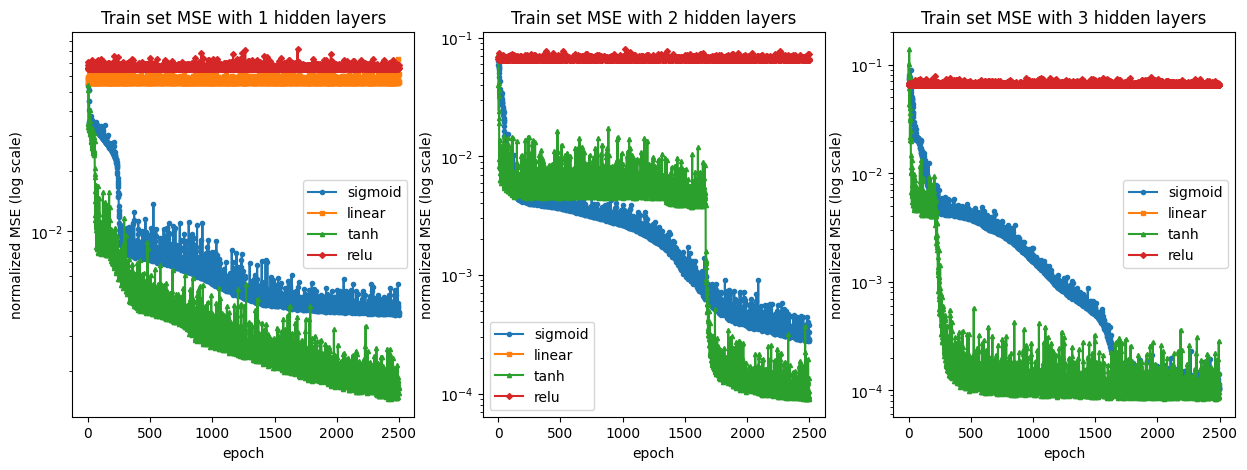

sigmoid 1 hidden layers: train MSE=154.35, test MSE=159.40
sigmoid 2 hidden layers: train MSE=11.09, test MSE=9.54
sigmoid 3 hidden layers: train MSE=4.12, test MSE=2.04
linear 1 hidden layers: train MSE=2211.46, test MSE=2231.00
linear 2 hidden layers: train MSE=nan, test MSE=nan
linear 3 hidden layers: train MSE=nan, test MSE=nan
tanh 1 hidden layers: train MSE=61.26, test MSE=58.90
tanh 2 hidden layers: train MSE=4.17, test MSE=1.55
tanh 3 hidden layers: train MSE=5.68, test MSE=3.43
relu 1 hidden layers: train MSE=2618.97, test MSE=2638.93
relu 2 hidden layers: train MSE=2589.08, test MSE=2610.89
relu 3 hidden layers: train MSE=2601.31, test MSE=2624.73


In [72]:
import itertools

layers_list = [[1, 10, 1],
               [1, 10, 10, 1],
                [1, 10, 10, 10, 1]]
act_fun_list = ['sigmoid', 'linear', 'tanh', 'relu']

labels = []
mse_train = []
mse_test = []

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].set_xlabel('epoch')
    ax[i].set_ylabel('normalized MSE (log scale)')
    ax[i].set_yscale('log')
    ax[i].set_title(f'Train set MSE with {i + 1} hidden layers')

epochs = 2500
markers = {'sigmoid': 'o', 'linear': 's', 'tanh': '^', 'relu': 'D'}
i=0

for act_fun, layers in itertools.product(act_fun_list, layers_list):
    labels.append(f'{act_fun} {len(layers) - 2} hidden layers')
    model = MLP(layer_sizes=layers, act_fun=act_fun, out_act_fun_name='linear', loss_fun_name='mse')
    losses = model.fit(X_train_norm, Y_train_norm, first_lr=0.1, epochs=epochs, n_epochs_displayed=100, batch_size=32, return_metrics=False, track_weights=False, optimizer='momentum', momentum_coef=0.9)
    ax[i].plot(range(epochs), losses, label=act_fun, marker=markers[act_fun], markersize=3)
    mse_train.append(model.loss_fun(Y_train, denormalize(model.predict(X_train_norm), y_min, y_max)))
    mse_test.append(model.loss_fun(Y_test, denormalize(model.predict(X_test_norm), y_min, y_max)))
    i += 1
    if i == 3:
        i = 0


for i in range(3):
    ax[i].legend()
plt.show()

for i in range(len(labels)):
    print(f'{labels[i]}: train MSE={mse_train[i]:.2f}, test MSE={mse_test[i]:.2f}')


Choosing: sigmoid with 3 hidden layers & tanh with 3 hidden layers

# steps-large

In [77]:
X_train = pd.read_csv('data/regression/steps-large-training.csv', index_col=0)['x']
Y_train = pd.read_csv('data/regression/steps-large-training.csv', index_col=0)['y']
X_test = pd.read_csv('data/regression/steps-large-test.csv', index_col=0)['x']
Y_test = pd.read_csv('data/regression/steps-large-test.csv', index_col=0)['y']

In [78]:
X_train_norm, x_min, x_max = normalize(X_train)
Y_train_norm, y_min, y_max = normalize(Y_train)
X_test_norm, _, _ = normalize(X_test, x_min, x_max)

In [81]:
model_sigmoid = MLP([1, 10, 10, 10, 1], act_fun='sigmoid', out_act_fun_name='linear', loss_fun_name='mse', metric='mse')
model_tanh = MLP([1, 10, 10, 10, 1], act_fun='tanh', out_act_fun_name='linear', loss_fun_name='mse', metric='mse')

epochs = 2000
first_lr = 0.1

losses_sigmoid = model_sigmoid.fit(X_train_norm, Y_train_norm, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=False, track_weights=False)
losses_tanh = model_tanh.fit(X_train_norm, Y_train_norm, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=False, track_weights=False)

Epoch 1: loss_fun=0.08594452275107343
Epoch 100: loss_fun=0.004957117873723935
Epoch 200: loss_fun=0.004158528281938248
Epoch 300: loss_fun=0.004834648585806592
Epoch 400: loss_fun=0.003875374202756625
Epoch 500: loss_fun=0.003935072982477839
Epoch 600: loss_fun=0.00394468625762334
Epoch 700: loss_fun=0.0039754924423967275
Epoch 800: loss_fun=0.004619906857992408
Epoch 900: loss_fun=0.0033995762888854118
Epoch 1000: loss_fun=0.0032144800811224534
Epoch 1100: loss_fun=0.0029578997230899884
Epoch 1200: loss_fun=0.003140195957631785
Epoch 1300: loss_fun=0.0029664451931493896
Epoch 1400: loss_fun=0.0029572001767072635
Epoch 1500: loss_fun=0.002988097197686578
Epoch 1600: loss_fun=0.0030155406937025027
Epoch 1700: loss_fun=0.0030086766666040533
Epoch 1800: loss_fun=0.0030816329515988353
Epoch 1900: loss_fun=0.002951550578986949
Epoch 2000: loss_fun=0.0028917960983750384
Epoch 1: loss_fun=0.0848533189325652
Epoch 100: loss_fun=0.005353733075668044
Epoch 200: loss_fun=0.0009071110991093603
Ep

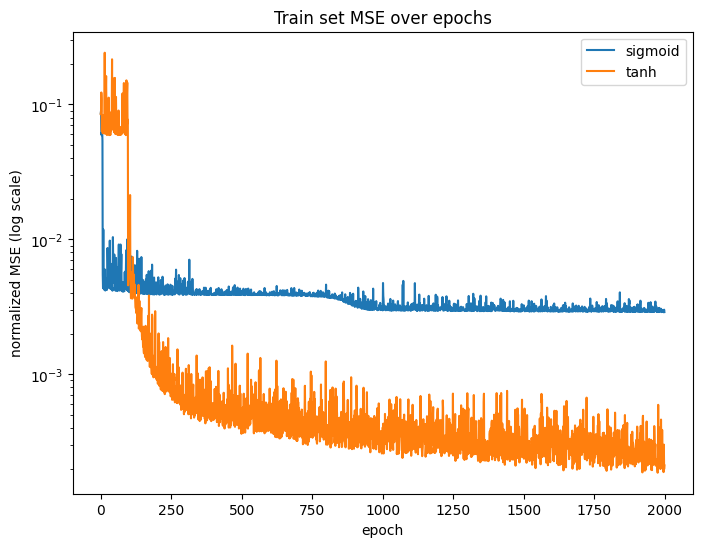

In [84]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(epochs), losses_sigmoid, label='sigmoid')
ax.plot(range(epochs), losses_tanh, label='tanh')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('normalized MSE (log scale)')
ax.set_title('Train set MSE over epochs')
ax.legend()
plt.show()

# rings5-regular

In [13]:
X_train = pd.read_csv('data/classification/rings5-regular-training.csv', index_col=None)[['x', 'y']]
Y_train = pd.read_csv('data/classification/rings5-regular-training.csv', index_col=None)['c']
X_test = pd.read_csv('data/classification/rings5-regular-test.csv', index_col=None)[['x', 'y']]
Y_test = pd.read_csv('data/classification/rings5-regular-test.csv', index_col=None)['c']

In [14]:
X_train_norm, x_min, x_max = normalize(X_train)
Y_train_norm = pd.get_dummies(Y_train)
X_test_norm, _, _ = normalize(X_test, x_min, x_max)

In [23]:
model_sigmoid = MLP([2, 10, 10, 10, 5], act_fun='sigmoid', out_act_fun_name='softmax', loss_fun_name='cross_entropy', metric='f1')
model_tanh = MLP([2, 10, 10, 10, 5], act_fun='tanh', out_act_fun_name='softmax', loss_fun_name='cross_entropy', metric='f1')

epochs = 2000
first_lr = 0.1

losses_sigmoid, f1_sigmoid = model_sigmoid.fit(X_train_norm, Y_train_norm, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=True, track_weights=False)
losses_tanh, f1_tanh = model_tanh.fit(X_train_norm, Y_train_norm, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=True, track_weights=False)

Epoch 1: loss_fun=1.7255636651382382, f1_score=0.06666666666666667
Epoch 100: loss_fun=1.6146480695701522, f1_score=0.06666666666666667
Epoch 200: loss_fun=1.6128717012859217, f1_score=0.06666666666666667
Epoch 300: loss_fun=1.6245241514499091, f1_score=0.06666666666666667
Epoch 400: loss_fun=1.6127342520318517, f1_score=0.06666666666666667
Epoch 500: loss_fun=1.1166803893195054, f1_score=0.4494568259323934
Epoch 600: loss_fun=0.4394724992029794, f1_score=0.8124898923669125
Epoch 700: loss_fun=0.32113487527638857, f1_score=0.8576815272166691
Epoch 800: loss_fun=0.30488911139947056, f1_score=0.8758322505282654
Epoch 900: loss_fun=0.19254097779551402, f1_score=0.9201409817306722
Epoch 1000: loss_fun=0.15956033235430342, f1_score=0.9414805082686597
Epoch 1100: loss_fun=0.17394639035870643, f1_score=0.9334792933382309
Epoch 1200: loss_fun=0.1477729111819327, f1_score=0.9472034295929805
Epoch 1300: loss_fun=0.1341213343294696, f1_score=0.9503534295026773
Epoch 1400: loss_fun=0.0893721875418

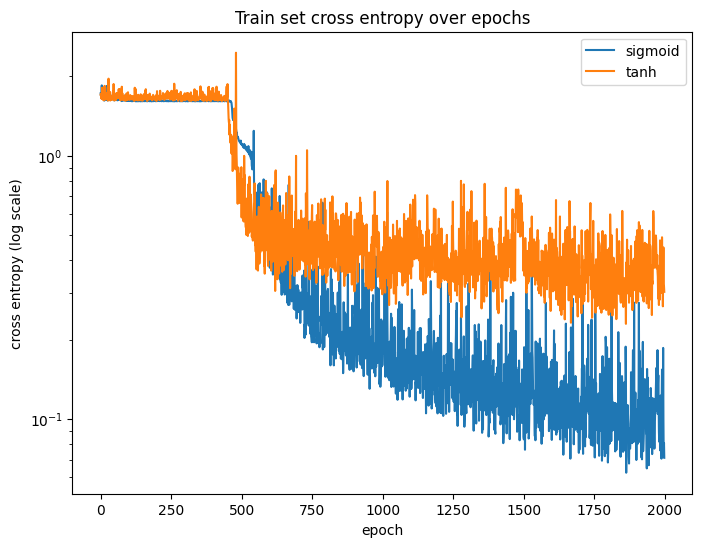

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(epochs), losses_sigmoid, label='sigmoid')
ax.plot(range(epochs), losses_tanh, label='tanh')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('cross entropy (log scale)')
ax.set_title('Train set cross entropy over epochs')
ax.legend()
plt.show()

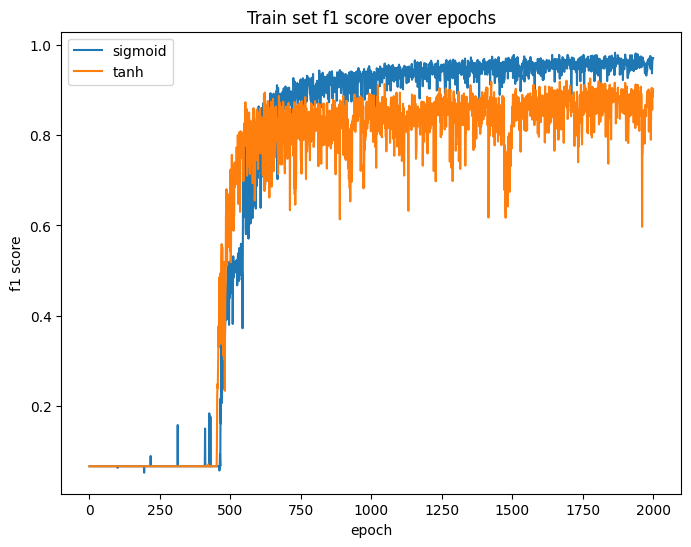

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(epochs), f1_sigmoid, label='sigmoid')
ax.plot(range(epochs), f1_tanh, label='tanh')
# ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('f1 score')
ax.set_title('Train set f1 score over epochs')
ax.legend()
plt.show()

# rings3-regular

In [27]:
X_train = pd.read_csv('data/classification/rings3-regular-training.csv', index_col=None)[['x', 'y']]
Y_train = pd.read_csv('data/classification/rings3-regular-training.csv', index_col=None)['c']
X_test = pd.read_csv('data/classification/rings3-regular-test.csv', index_col=None)[['x', 'y']]
Y_test = pd.read_csv('data/classification/rings3-regular-test.csv', index_col=None)['c']

In [28]:
X_train_norm, x_min, x_max = normalize(X_train)
Y_train_norm = pd.get_dummies(Y_train)
X_test_norm, _, _ = normalize(X_test, x_min, x_max)

In [29]:
model_sigmoid = MLP([2, 10, 10, 10, 3], act_fun='sigmoid', out_act_fun_name='softmax', loss_fun_name='cross_entropy', metric='f1')
model_tanh = MLP([2, 10, 10, 10, 3], act_fun='tanh', out_act_fun_name='softmax', loss_fun_name='cross_entropy', metric='f1')

epochs = 2000
first_lr = 0.1

losses_sigmoid, f1_sigmoid = model_sigmoid.fit(X_train_norm, Y_train_norm, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=True, track_weights=False)
losses_tanh, f1_tanh = model_tanh.fit(X_train_norm, Y_train_norm, first_lr=first_lr, epochs=epochs, n_epochs_displayed=100, batch_size=32, momentum_coef=0.9, optimizer='momentum', return_metrics=True, track_weights=False)

Epoch 1: loss_fun=1.102085175755872, f1_score=0.16666666666666666
Epoch 100: loss_fun=1.1764644308023933, f1_score=0.16666666666666666
Epoch 200: loss_fun=0.9751996966583517, f1_score=0.3664168036587146
Epoch 300: loss_fun=0.7192759451690035, f1_score=0.6395676701118921
Epoch 400: loss_fun=0.25476434374334783, f1_score=0.896177813242022
Epoch 500: loss_fun=0.12826758969178279, f1_score=0.9461900014470702
Epoch 600: loss_fun=0.0840968232704697, f1_score=0.9666810956400452
Epoch 700: loss_fun=0.09069646671284151, f1_score=0.9619324440781275
Epoch 800: loss_fun=0.16858721585719932, f1_score=0.9379214341493589
Epoch 900: loss_fun=0.08871421627757026, f1_score=0.9632673377380451
Epoch 1000: loss_fun=0.06208653028491945, f1_score=0.9780049014365445
Epoch 1100: loss_fun=0.09550803908519144, f1_score=0.9579143380333436
Epoch 1200: loss_fun=0.060574621423238606, f1_score=0.9779393845224664
Epoch 1300: loss_fun=0.06886499526680832, f1_score=0.9719606645231925
Epoch 1400: loss_fun=0.0893393173220

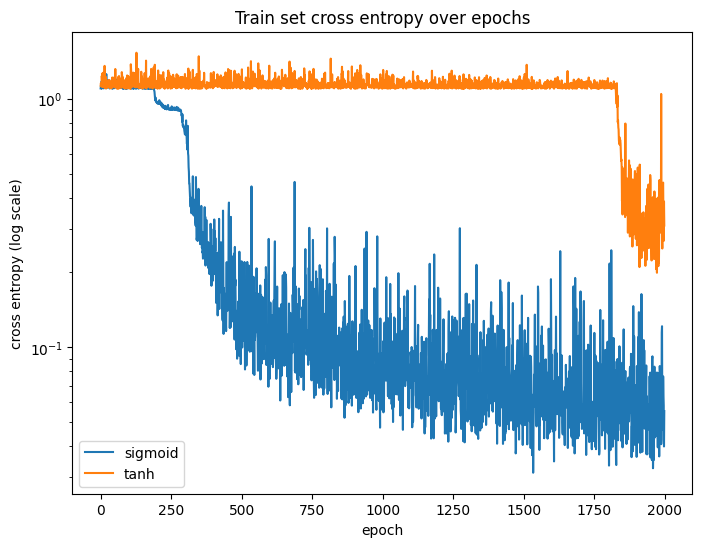

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(epochs), losses_sigmoid, label='sigmoid')
ax.plot(range(epochs), losses_tanh, label='tanh')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('cross entropy (log scale)')
ax.set_title('Train set cross entropy over epochs')
ax.legend()
plt.show()

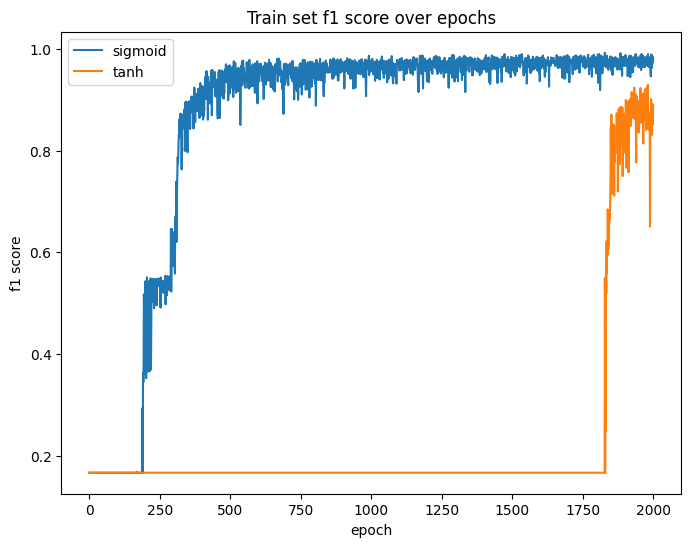

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(epochs), f1_sigmoid, label='sigmoid')
ax.plot(range(epochs), f1_tanh, label='tanh')
# ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('f1 score')
ax.set_title('Train set f1 score over epochs')
ax.legend()
plt.show()